In [1]:
%load_ext autoreload
%autoreload 2

### Data setup

In [80]:
import matplotlib.pyplot as plt
from prod.engine_utils import * 

def cohort_grouper(df, group_key='cohort_date', 
                   target_variables=['active_users_users'],\
                   group_statics=['dx'], 
                   group_freq='W', group_function=np.sum):
    return df.groupby([pd.Grouper(key=group_key, freq=group_freq)] + group_statics)[target_variables]\
             .agg(group_function)\
             .reset_index()

def remove_nans_from_array(y):
    return y[~np.isnan(y)]

def count_nons_nans_in_array(y):
    return np.count_nonzero(~np.isnan(y))

def nan_padding(x, target_length):
    # padding sequences with nans in order to speed up computation with batches
    # use with caution and propagating nans
    return x + [np.nan] * (target_length - len(x))

def init_nans(shapes):
    x = np.zeros(shapes)
    x[:] = np.nan
    return x

def avg_std_retention_curve(df):
    df['sq_au'] = df['active_users']**2
    std_ret_df = np.sqrt(df.groupby('dx')['sq_au'].sum() / df.groupby('dx')['cohort_size'].sum())
    std_ret_df = pd.Series(np.where(std_ret_df.index > 90, std_ret_df[90], std_ret_df), index=std_ret_df.index)
    df = pd.merge(df, std_ret_df.rename('std_retention'),
             left_on='dx', right_index=True
        )
    
    avg_retention_curve = (df.groupby('dx')['active_users'].sum() / df.groupby('dx')['cohort_size'].sum())
    avg_retention_curve = pd.Series(np.where(avg_retention_curve.index > 90, avg_retention_curve[90], avg_retention_curve), index=avg_retention_curve.index)
    
    
    return pd.merge(df, avg_retention_curve.rename('avg_retention'),
             left_on='dx', right_index=True
            )

In [93]:
filename ='clf_data/clf_sparse_retention_dataset.parquet'#clf_parquet_thomas_sample_cohortised_aprdau.parquet'#
raw_data = pd.read_parquet(filename)

#.query("country=='US' and platform=='ANDROID' and channel=='organic'")\#
#.pipe(cohort_grouper, target_variables=['active_users'])\
segment_data = raw_data\
.query("country=='US' and platform=='ANDROID' and channel=='organic'")\
.dropna()\
.pipe(calculate_days_since_install)\
.pipe(format_date_column, column='cohort_date')\
.pipe(calculate_activity_date)
segment_data['dx']=segment_data['dx'].astype(int)

active_users_df = segment_data[['calendar_date','cohort_date','dx','active_users']].reset_index(drop=True).copy()
cohort_size_df = segment_data.query('dx==0')[['cohort_date','active_users']]\
                           .rename({'active_users':'cohort_size'},axis=1)\
                           .reset_index(drop=True).copy()


full_domain_dimensions = generate_ranged_clf_dataframe(
                start_date=segment_data['cohort_date'].min(),#config_nn['start_input_date'],
                end_date=segment_data['cohort_date'].max()#config_nn['end_forecast_date'],
            )

actual_input = (
    full_domain_dimensions[['cohort_date','dx']]
    .merge(active_users_df, on=['cohort_date','dx'], how='left')
    .merge(cohort_size_df, on=['cohort_date'], how='left')
    .assign(retention=lambda x: x['active_users']/x['cohort_size'])
    .fillna({"cohort_size": 0,"retention": 0,"active_users": 0})
    .pipe(calculate_activity_date)
    .assign(
                lag1_cohort_date=lambda df: df.groupby(["dx"])["retention"].shift(1),
                lag7_cohort_date=lambda df: df.groupby(["dx"])["retention"].shift(7),
                lag1_dx=lambda df: df.groupby(["cohort_date"])["retention"].shift(1),
                day_of_week_sin = lambda df: np.sin(df['calendar_date'].dt.weekday * (2 * np.pi / 7)),
                day_of_week_cos = lambda df: np.cos(df['calendar_date'].dt.weekday * (2 * np.pi / 7))
            )
            .assign(
                lag1_cohort_date=lambda df: np.where(
                    df["lag1_cohort_date"].isna(),
                    df["retention"],
                    df["lag1_cohort_date"],
                ),
                lag7_cohort_date=lambda df: np.where(
                    df["lag7_cohort_date"].isna(),
                    1.0,
                    df["lag7_cohort_date"],
                ),
                lag1_dx=lambda df: np.where(
                    df["lag1_dx"].isna(), df["retention"], df["lag1_dx"]
                ),
                log_dnu=lambda df: np.log1p(df["cohort_size"]),
                log_dx=lambda df: np.log1p(df["dx"]),
            )
    .query("dx > 0")
    #.query("dx < 300")
    .query("cohort_size > 3")
    .reset_index(drop=True)
    .copy()
)

In [100]:
def avg_std_retention_curve(df):
    MAX_DX = 90

    df['active_users'] = df['retention'] * df['cohort_size']
    df['sq_au'] = df['active_users']**2

    std_retention_df = np.sqrt(df[df['dx'] < MAX_DX].groupby('dx')['sq_au'].sum() / df[df['dx'] < MAX_DX].groupby('dx')['cohort_size'].sum())
    avg_retention_df = (df[df['dx'] < MAX_DX].groupby('dx')['active_users'].sum() / df[df['dx'] < MAX_DX].groupby('dx')['cohort_size'].sum())

    df = (
        pd.merge(df, std_retention_df.rename("std_retention"), left_on='dx', right_index=True)
        .fillna({"std_retention": std_retention_df.values[-1]})
        .merge(avg_retention_df.rename("avg_retention"), left_on='dx', right_index=True)
        .fillna({"avg_retention": avg_retention_df.values[-1]})
        .eval("norm_retention = (retention - avg_retention) / std_retention")
    )

    return df.drop(["sq_au","std_retention","avg_retention"], axis=1)

In [101]:
avg_std_retention_curve(actual_input)

,cohort_date,dx,calendar_date,active_users,cohort_size,retention,lag1_cohort_date,lag7_cohort_date,lag1_dx,day_of_week_sin,day_of_week_cos,log_dnu,log_dx,norm_retention
0,2019-03-22,1,2019-03-23,0.0,5.0,0.000000,0.000000,1.00,1.0,-0.974928,-0.222521,1.791759,0.693147,-0.060198
1133,2019-04-03,1,2019-04-04,1.0,4.0,0.250000,0.000000,0.00,1.0,0.433884,-0.900969,1.609438,0.693147,-0.019681
2254,2019-04-05,1,2019-04-06,8.0,17.0,0.470588,0.000000,0.00,1.0,-0.974928,-0.222521,2.890372,0.693147,0.016068
3373,2019-04-06,1,2019-04-07,1.0,5.0,0.200000,0.470588,0.00,1.0,-0.781831,0.623490,1.791759,0.693147,-0.027785
4491,2019-04-10,1,2019-04-11,1.0,4.0,0.250000,0.333333,0.25,1.0,0.433884,-0.900969,1.609438,0.693147,-0.019681
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
603490,2022-01-25,89,2022-04-24,0.0,10.0,0.000000,0.153846,0.00,0.0,-0.781831,0.623490,2.397895,4.499810,-0.054743
603583,2022-01-26,89,2022-04-25,0.0,11.0,0.000000,0.000000,0.00,0.0,0.000000,1.000000,2.484907,4.499810,-0.054743
603675,2022-01-27,89,2022-04-26,0.0,10.0,0.000000,0.000000,0.00,0.0,0.781831,0.623490,2.397895,4.499810,-0.054743
603766,2022-01-28,89,2022-04-27,0.0,8.0,0.000000,0.000000,0.00,0.0,0.974928,-0.222521,2.197225,4.499810,-0.054743


In [70]:
actual_input['sq_au'] = actual_input['active_users']**2
std_ret_df = np.sqrt(actual_input.groupby('dx')['sq_au'].sum() / actual_input.groupby('dx')['cohort_size'].sum())
std_ret_df = pd.Series(np.where(std_ret_df.index > 90, std_ret_df[90], std_ret_df), index=std_ret_df.index)
actual_input = pd.merge(actual_input, std_ret_df.rename('std_retention'),
         left_on='dx', right_index=True
        )
actual_input['norm_retention'] = (actual_input['retention']-actual_input['avg_retention'])/actual_input['std_retention']

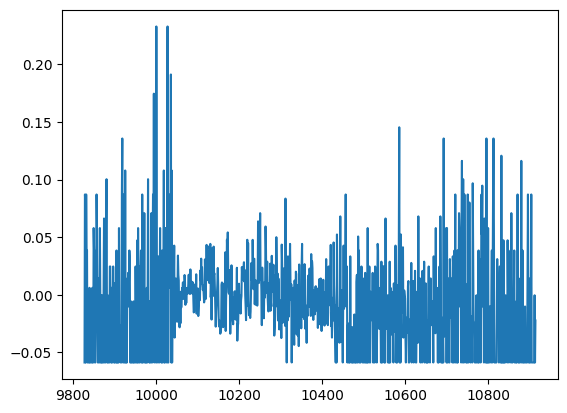

In [79]:
plt.plot(actual_input[actual_input.dx==10]['norm_retention'])

(0.01, 1)

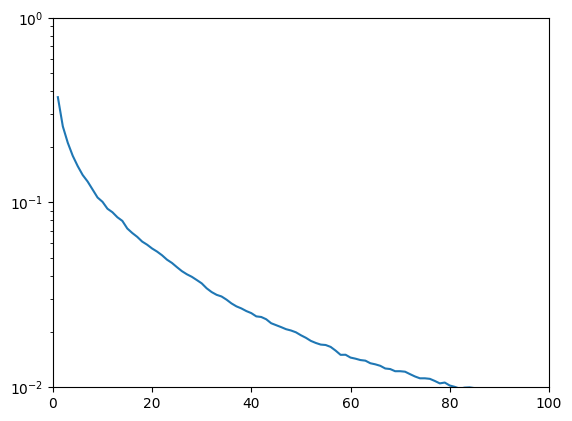

In [26]:
plt.semilogy(actual_input.groupby('dx')['active_users'].sum() / actual_input.groupby('dx')['cohort_size'].sum())
plt.xlim([0,100]); plt.ylim([0.01,1])

In [ ]:
np.where()

In [ ]:
actual_input.cohort_date.min(), actual_input.cohort_date.max()
train_test_sep_date = pd.to_datetime('2022-01-01')

In [ ]:
train_domain = generate_ranged_clf_dataframe(
            start_date=actual_input.cohort_date.min(),
            end_date=train_test_sep_date,
        ).assign(domain = 'train')

In [ ]:
actual_input = actual_input.merge(train_domain, on=['cohort_date','dx'], how='left')
actual_input['domain'] = actual_input['domain'].fillna('test')

In [ ]:
nodes_pivot_df = actual_input.pivot(index='cohort_date', columns='dx',values='index')
nodes_pivot = nodes_pivot_df.values

In [ ]:
top_neighbour = init_nans(nodes_pivot.shape)
left_neighbour = init_nans(nodes_pivot.shape)
for i in range(nodes_pivot.shape[0]):
    for j in range(nodes_pivot.shape[1]):
        if j != 0:
            top_neighbour[i,j] = nodes_pivot[i,j-1]
        if i != 0:
            left_neighbour[i,j] = nodes_pivot[i-1,j]

In [ ]:
top_neighbour_df = pd.DataFrame(top_neighbour, index=nodes_pivot_df.index, columns=nodes_pivot_df.columns)
left_neighbour_df = pd.DataFrame(left_neighbour, index=nodes_pivot_df.index, columns=nodes_pivot_df.columns)

In [ ]:
top_edges = (
nodes_pivot_df
    .unstack()
    .to_frame()
    .merge(top_neighbour_df
           .unstack()
           .to_frame(), left_index=True, right_index=True, suffixes=('_node','_top'))
    .dropna()
    .merge(actual_input[['index','retention','domain']], left_on='0_top', right_on='index')
    [['0_top','0_node','retention','domain']]
)

left_edges = (
nodes_pivot_df
    .unstack()
    .to_frame()
    .merge(left_neighbour_df
           .unstack()
           .to_frame(), left_index=True, right_index=True, suffixes=('_node','_left'))
    .dropna()
    .merge(actual_input[['index','retention','domain']], left_on='0_left', right_on='index')
    [['0_left','0_node','retention','domain']]
)

In [ ]:
from torch_geometric.datasets import TUDataset, GNNBenchmarkDataset, Planetoid
from torch_geometric.loader import DataLoader
from torch_geometric.data import Data, Dataset
from torch_geometric.transforms import RandomNodeSplit

from torch_geometric.nn import Sequential, GCNConv, global_mean_pool, GATConv
from torch.nn import Dropout, Linear, ReLU, Sigmoid
from torch import nn 
#from torchmetrics.functional import accuracy, precision_recall, confusion_matrix
import torch
import torch.nn.functional as F

In [ ]:
def get_domain_data(domain):
    edges_arr = np.concatenate((top_edges[top_edges.domain==domain][['0_top','0_node','retention']].values, 
                                left_edges[left_edges.domain==domain][['0_left','0_node','retention']].values))
    target_arr = actual_input[actual_input.domain==domain]['retention'].values
    
    features_list = [
            "log_dnu",
            "log_dx",
            "lag1_cohort_date",
            "lag7_cohort_date",
            "lag1_dx",
            "day_of_week_sin",
            "day_of_week_cos",
        ]
    features_arr = actual_input[actual_input.domain==domain][features_list].values
    return edges_arr, target_arr, features_arr

def get_data():
    edges_arr = np.concatenate((top_edges[['0_top','0_node']].values, 
                                left_edges[['0_left','0_node']].values))
    target_arr = actual_input['retention'].values
    
    features_list = [
            "log_dnu",
            "log_dx",
            "lag1_cohort_date",
            "lag7_cohort_date",
            "lag1_dx",
            "day_of_week_sin",
            "day_of_week_cos",
        ]
    features_arr = actual_input[features_list].values
    return edges_arr, target_arr, features_arr

#train_edges, train_target, train_features = get_data('train')
#test_edges, test_target, test_features = get_data('test')
#convert_indices = dict(zip(np.unique(train_edges[:,:2]).astype(int), np.arange(0, len(np.unique(train_edges[:,:2])))))
#new_train_edges = np.zeros_like(train_edges[:,:2])
#for i in range(new_train_edges.shape[0]):
#    for j in range(new_train_edges.shape[1]):
#        new_train_edges[i,j] = convert_indices[train_edges[i,j]]

In [ ]:
edges_arr, target_arr, features_arr = get_data()

x = torch.from_numpy(features_arr).float()
y = torch.from_numpy(target_arr).unsqueeze(1).float()
edge_index = torch.from_numpy(edges_arr).t().to(torch.int64)

# building the Data graph
retention_graph_data = Data(x=x, edge_index=edge_index, y=y) 

spliter = RandomNodeSplit(split='train_rest',
                num_val=0.0,
                num_test=0.0
               )

retention_graph_data = spliter(retention_graph_data)

In [ ]:
class RetentionGCN(torch.nn.Module):
    def __init__(self, n_features, latent_layer_1=16, latent_layer_2=4):
        super().__init__()
        """ GCNConv layers """
        self.latent_layer_1 = latent_layer_1
        self.latent_layer_2 = latent_layer_2
        
        self.n_features = n_features
        
        self.model = Sequential("x, edge_index",
                                [
                                    (GCNConv(self.n_features, self.latent_layer_1), "x, edge_index -> h1"),
                                    (ReLU(), "h1 -> r1"),
                                    (Dropout(p=0.2), "r1 -> d1"),
                                    (GCNConv(self.latent_layer_1, self.latent_layer_2), "d1, edge_index -> h2"),
                                    (ReLU(), "h2 -> r2"),
                                    (Dropout(p=0.2), "r2 -> d2"),
                                    (Linear(self.latent_layer_2, 1), "d2 -> a3"),
                                    (Sigmoid(), "a3 -> x_output")
                                ]
                               )
        #self.conv1 = GCNConv(self.n_features, self.latent_layer_1)
        #self.relu1 = ReLU()
        #self.dropout1 = Dropout(p=0.2)
        
        #self.conv2 = GCNConv(self.latent_layer_1, self.latent_layer_2)
        
        #self.layer_out = Linear(self.latent_layer_2, 1) 
        #self.sigmoid = Sigmoid()
        
    def forward(self, x, edge_index):
        
        x_output = self.model(x, edge_index)

        return x_output

In [ ]:
from torch_geometric.loader import DataLoader, NeighborLoader

In [ ]:
loader = NeighborLoader(
    retention_graph_data,
    # Sample 30 neighbors for each node for 2 iterations
    num_neighbors=[5] * 2,
    # Use a batch size of 128 for sampling training nodes
    batch_size=128,
)

In [ ]:
model = RetentionGCN(retention_graph_data.num_features)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)
loss_function = torch.nn.MSELoss(reduction='mean')

In [ ]:
training_labelled_mask = retention_graph_data.train_mask
test_labelled_mask = retention_graph_data.test_mask

In [ ]:
data

In [ ]:
# train the model
model.train()
losses = []
train_accuracies = []
test_accuracies = []

for epoch in range(40):
    epoch_loss = 0
    epoch_test_loss = 0
    
    for data in loader:
        optimizer.zero_grad()
        xtrain = data.x[data.train_mask]
        edge_train = data.edge_index
        out = model(xtrain, edge_train).view(-1) # flatten

        loss = loss_function(out, 
                             data.y[data.train_mask].float().view(-1),
                            )
    
        loss.backward()
        epoch_loss += loss.item()
        optimizer.step()
        
        # evaluation metrics
        
        xtest = data.x[data.test_mask]
        edge_test = data.edge_index
        #test_loss = F.mse_loss(model(xtest, edge_test), data.y[data.test_mask])
        #epoch_test_loss += test_loss.item()
        
    losses.append(loss.item())
    # take first element of each eval metric to get the metric of class 0 (illicit transactions)
    train_accuracies.append(epoch_loss)
    #test_accuracies.append(epoch_test_loss)
    
    print(epoch+1, 
      "{:.2f}".format(epoch_loss), 
      "{:.2f}".format(epoch_test_loss),
      sep='\t')

    # early stopping
    if len(test_accuracies) > 20:
        if np.mean(test_accuracies[-4:]) > np.mean(test_accuracies[-5:-1]): # little moving average on 4 consecutive epochs to be sure it's globally goign up
            print('\nEarly stopping')
            print(f"Epoch {epoch}, loss {epoch_loss}, test_loss {epoch_test_loss}")
            break

In [ ]:
model.eval()
output = []
n_ids = []
with torch.no_grad():

    for data in loader:
        xtrain = data.x[data.train_mask]
        out = model(xtrain, edge_train).view(-1) # flatten
        output.append(out)
        n_ids.append(data.n_id)

In [ ]:
outputs = [o for out in output for o in out.detach().tolist()]
nodes = [o for out in n_ids for o in out.detach().tolist()]

In [ ]:
results = pd.DataFrame(zip(outputs,nodes), columns=['ypred','nodes'])

In [ ]:
nodes_pivot_df.unstack().dropna().reset_index()[0].max()

In [ ]:
852908/3

In [ ]:
results[results.nodes==1]

In [ ]:
nodes_pivot_df.unstack().reset_index().merge(results, left_on=0,right_on='nodes')

In [ ]:
class GDPModel(torch.nn.Module):
    def __init__(self, num_features=2, hidden_size=8, target_size=1):
        super().__init__()
        self.hidden_size = hidden_size
        self.num_features = num_features
        self.target_size = target_size
        self.convs = [GATConv(self.num_features, self.hidden_size, edge_dim = 1),
                      GATConv(self.hidden_size, self.hidden_size, edge_dim = 1)]
        self.linear = nn.Linear(self.hidden_size, self.target_size)

    def forward(self, data):
        x, edge_index, edge_attr = data.x, data.edge_index, data.edge_attr
        for conv in self.convs[:-1]:
            x = conv(x, edge_index, edge_attr=edge_attr) # adding edge features here!
            x = F.relu(x)
            x = F.dropout(x, training=self.training)
        x = self.convs[-1](x, edge_index, edge_attr=edge_attr) # edge features here as well
        x = self.linear(x)

        return F.sigmoid(x) 

In [ ]:
def train(model, name_prefix, hyperparams):
    ''' 
    Train model with given hyperparams dict.
    Saves the following CSVs over the course of training:
    1. the loss trajectory: the val and train loss every save_loss_interval epochs at
       filename 'results/{name_prefix}_{learning_rate}_train.csv' e.g. 'results/baseline_0.05_train.csv'
    2. every save_model_interval save both the model at e.g. 'models/baseline_0.05_0_out_of_1000.pt`
       and the predicted values vs actual values in `results/baseline_0.05_0_out_of_1000_prediction.csv' on the test data.
    '''
    learning_rate = hyperparams['learning_rate']
    batch_size = hyperparams['batch_size']
    n_epochs = hyperparams['n_epochs']
    save_loss_interval = hyperparams['save_loss_interval']
    print_interval = hyperparams['print_interval']
    save_model_interval = hyperparams['save_model_interval']

    optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)
    loader = DataLoader(data_train, batch_size=batch_size, shuffle=True)
    losses = []
    test_data = data_test[0]
    for epoch in range(n_epochs):
        epoch_loss = 0
        model.train()
        for data in loader:
            optimizer.zero_grad()
            out = model(data)
            loss = F.mse_loss(out, data.y)
            epoch_loss += loss.item() 
            loss.backward()
            optimizer.step()
        if epoch % save_loss_interval == 0:
            val_loss = evaluate_model(model, data_val) / NUM_VAL
            train_loss = epoch_loss / NUM_TRAIN * batch_size
            if epoch % print_interval == 0:
                print("Epoch: {} Train loss: {:.2e} Validation loss: {:.2e}".format(epoch, train_loss, val_loss))
            losses.append((epoch, train_loss, val_loss))
        if epoch % save_model_interval == 0:
            # save predictions for plotting
            model.eval()

    return losses

In [ ]:
hyperparams = {
    'batch_size' : 3, 
    'save_loss_interval' : 10, 
    'print_interval' : 50,
    'save_model_interval' : 250,
    'n_epochs' : 1500,
    'learning_rate' : 0.01
}

In [ ]:
print("Training model...")
model = GDPModel().float() # needs to be double precision
model_loss_traj = train(model, "model", hyperparams)

In [107]:
import seaborn as sns

In [108]:
aa = pd.read_csv("whatcha.csv")

In [111]:
aa.pivot(index='cohort_date',columns='dx',values='retention')

dx,0.0,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,...,655.0,656.0,657.0,658.0,659.0,660.0,661.0,662.0,663.0,664.0
cohort_date,,,,,,,,,,,,,,,,,,,,,
2020-11-04,1.0,0.111293,0.066950,0.044990,0.036037,0.029471,0.025939,0.022905,0.019647,0.017658,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2020-11-05,1.0,0.106702,0.062212,0.043011,0.035222,0.028666,0.024747,0.023564,0.019719,0.018560,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN
2020-11-06,1.0,0.108599,0.063327,0.046411,0.036976,0.030239,0.026995,0.025336,0.020581,0.020259,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN
2020-11-07,1.0,0.110131,0.062421,0.043120,0.034593,0.029785,0.025800,0.026307,0.023239,0.019326,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN
2020-11-08,1.0,0.101104,0.063359,0.044984,0.035977,0.029198,0.027092,0.027068,0.022443,0.019683,...,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-08-26,0.0,0.000000,0.000000,0.000000,0.000000,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-08-27,0.0,0.000000,0.000000,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-08-28,0.0,0.000000,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


<Axes: xlabel='dx', ylabel='cohort_date'>

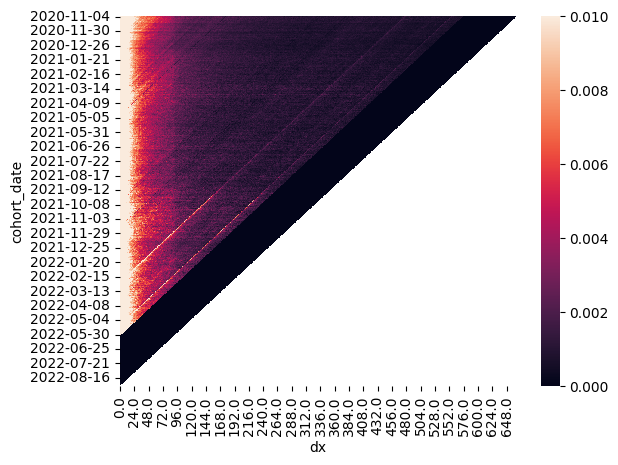

In [114]:
sns.heatmap(aa.pivot(index='cohort_date',columns='dx',values='retention'), vmin=0.0, vmax=0.01)

In [135]:
aa.pivot(index='cohort_date',columns='dx',values='retention').iloc[480:500,60:75]

dx,60.0,61.0,62.0,63.0,64.0,65.0,66.0,67.0,68.0,69.0,70.0,71.0,72.0,73.0,74.0
cohort_date,,,,,,,,,,,,,,,
2022-02-27,0.004240,0.004846,0.005048,0.004846,0.004947,0.004341,0.003635,0.004341,0.005048,0.003332,0.004644,0.003836,0.004644,0.004038,0.004240
2022-02-28,0.003116,0.003545,0.003760,0.004190,0.004190,0.004190,0.004512,0.003975,0.003545,0.003760,0.003545,0.003330,0.003223,0.004512,0.009991
2022-03-01,0.003929,0.004353,0.004141,0.004460,0.003610,0.003716,0.004035,0.002867,0.003822,0.002654,0.003504,0.002761,0.003185,0.010193,0.006583
2022-03-02,0.006246,0.004764,0.003917,0.004235,0.004023,0.005082,0.004235,0.003917,0.002752,0.004658,0.003599,0.003917,0.008999,0.006140,0.005082
2022-03-03,0.004677,0.005374,0.002886,0.003582,0.003483,0.003682,0.003284,0.003582,0.003980,0.003781,0.003483,0.008558,0.005772,0.004777,0.005075
2022-03-04,0.004266,0.003961,0.003555,0.003859,0.003352,0.004469,0.004063,0.003453,0.003961,0.003148,0.010055,0.005992,0.005992,0.003656,0.005891
2022-03-05,0.004088,0.004287,0.004786,0.003689,0.003789,0.003390,0.003390,0.002792,0.004088,0.008973,0.008375,0.006481,0.004786,0.004487,0.005184
2022-03-06,0.003756,0.003371,0.003563,0.003659,0.003467,0.002985,0.002696,0.002889,0.009438,0.005778,0.007126,0.004911,0.004911,0.003467,0.004045
2022-03-07,0.003481,0.004114,0.002848,0.002743,0.003481,0.003587,0.003059,0.009073,0.005802,0.004325,0.004009,0.004220,0.003798,0.003059,0.002637


In [137]:
pd.to_datetime('2022-03-14') + pd.Timedelta(60,'D')

Timestamp('2022-05-13 00:00:00')

<Axes: xlabel='dx', ylabel='cohort_date'>

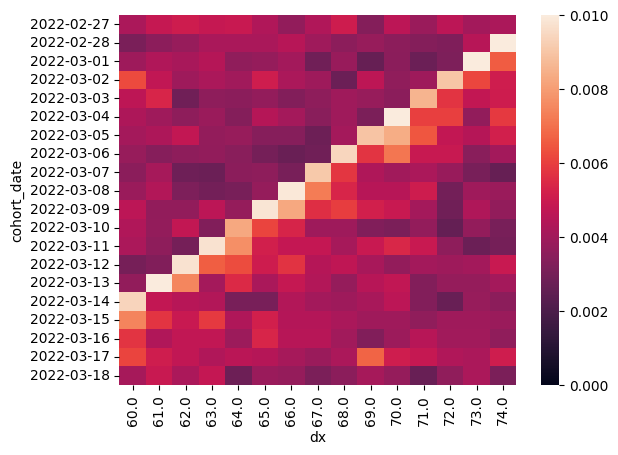

In [134]:
sns.heatmap(aa.pivot(index='cohort_date',columns='dx',values='retention').iloc[480:500,60:75], vmin=0.0, vmax=0.01)

<Axes: xlabel='dx', ylabel='cohort_date'>

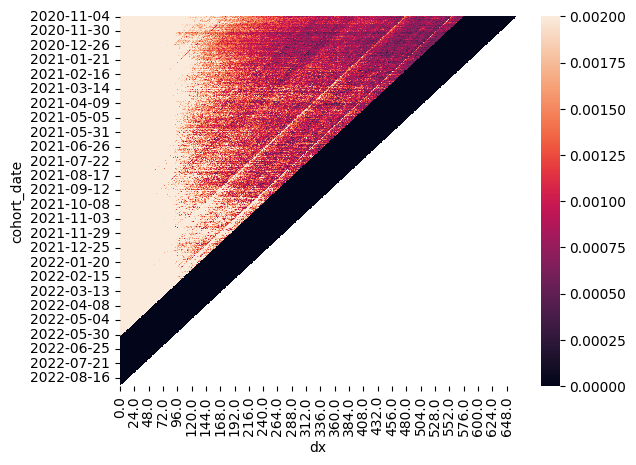

In [121]:
sns.heatmap(aa.pivot(index='cohort_date',columns='dx',values='lag1_cohort_date'), vmin=0.0, vmax=0.002)